In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

if os.getcwd()[-7:] == 'AAM_Sim':
    print(os.getcwd())
else:
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    print(os.getcwd())
    
from Engine.GlobalClock import GlobalClock, Agent
from Engine.State import State
from Engine.Aircraft import AircraftType
from Engine.FlightPlan import FlightPlan
from Engine.MultiRotorController import MultiRotorController
from Engine.Wind import WindField
from Engine.Sensors import NavUpdate, GPSPosNavUpdate
from Engine.DragModel import DragModel
from Engine.TrackingSystem import *
from Engine.ConflictDetector import ConflictDetector

from CrossPlatformDev import my_print, join_str

import time

C:\Users\quekz\PycharmProjects\AAM_Sim


In [2]:
def FP_gen(HDG, speed, time, num_wpts, ini_pos):
    """Function that generates a flight plan according to encounter design. 
    A/C have fixed heading and will fly toward WPTs. 
    HDG --> desired A/C HDG (counter-clockwise from x-axis in RADIANS)
    speed --> desired A/C cruise spd
    time --> approximate duration for each flight leg (between 2 consecutive wpts)
    num_wpts --> number of wpts along the flight path
    ini_pos --> initial position of the A/C
    """
    wpt_list = []
    wpt_times = []
    spds = []
    mode_list = []
    duration_list = []
    for i in range(num_wpts):
        wpt_list.append(ini_pos + i*speed*time*np.array([np.cos(HDG), np.sin(HDG), 0]))
        wpt_times.append(i*time*1.1) # Give a 10% margin to each leg duration
        if i > 0:
            spds.append(speed)
            mode_list.append('Direct_P2P')
            duration_list.append(time*1.1) # Give a 10% margin to each leg duration
    wpt_start_list = wpt_list[0:num_wpts-1]
    wpt_end_list = wpt_list[1:]
    wpt_start_time = wpt_times[0:num_wpts-1]
    wpt_end_time = wpt_times[1:]
    return (FlightPlan(spds, mode_list,
                       wpt_start_list, wpt_start_time,
                       wpt_end_list, wpt_end_time, duration_list), wpt_list)


def calc_diameter(mass):
    """Data for this function obtained from log-log plot of popular DJI quadrotors"""
    diameter = round(np.random.uniform(0.8, 1.2) * np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    return diameter

In [3]:
# File to be used for generating initial params

# Global Params

GlobalPhysicsUpdateRate = 240
GlobalSimStopTime = 150
Cruise_Leg_Time = 15
Num_Legs = 4

WindUpdateRate = 5
Wind_auto_x = 0.8
Wind_auto_y = 0
Wind_auto_z = 0
Wind_std_x = 3
Wind_std_y = 3
Wind_std_z = 0
Wind_mean_x = 0
Wind_mean_y = 0
Wind_mean_z = 0

# AC1 Params
AC1_Prop_Diameter = 9
AC1_Mass = 1.2
AC1_HDG = 0
AC1_HDG = AC1_HDG*np.pi/180
AC1_Cruise_Speed = 10
AC1_Ini_Pos_x, AC1_Ini_Pos_y, AC1_Ini_Pos_z = np.random.uniform(200,201) * np.array([-np.cos(AC1_HDG), 
                                                                                     -np.sin(AC1_HDG), 
                                                                                     0])
AC1_Ini_Vel_x, AC1_Ini_Vel_y, AC1_Ini_Vel_z = np.zeros(3)

AC1_GPS_horizontal_std = 3.5 # 15
AC1_GPS_horizontal_std = (AC1_GPS_horizontal_std)/np.sqrt(0.5*(4-np.pi))
# AC1_GPS_horizontal_std = (AC1_GPS_horizontal_std/2)/np.sqrt(0.5*(4-np.pi)) # Pls chk formula before running! 
AC1_GPS_horizontal_auto = 0.994

AC1_GPS_vert_std = 3.5 # 15
AC1_GPS_vert_auto = 0.994

AC1_Ini_Pos_Err_x, AC1_Ini_Pos_Err_y, AC1_Ini_Pos_Err_z = np.array([np.random.normal(0, AC1_GPS_horizontal_std), 
                                                                    np.random.normal(0, AC1_GPS_horizontal_std), 
                                                                    np.random.normal(0, AC1_GPS_vert_std)])
AC1_Ini_Vel_Err_x, AC1_Ini_Vel_Err_y, AC1_Ini_Vel_Err_z = np.zeros(3)
AC1_Ini_RPY_r, AC1_Ini_RPY_p, AC1_Ini_RPY_y = np.zeros(3)

AC1_PhysicsUpdateRate = GlobalPhysicsUpdateRate
AC1_Controller_UpdateRate = 120
AC1_Start_Time = 0

AC1_PosUpdateRate = 10
AC1_VelUpdateRate = 10
AC1_AccelUpdateRate = 120
AC1_AirSpdSensorUpdateRate = 120

# Initialize AC1 Tracking System

AC1_TrackingUnit_UpdateRate = 2
AC1_TrackingUnit_Pos_Quant = 0
AC1_TrackingUnit_Vel_Quant = 0
AC1_TrackingUnit_Avail = 0.5
AC1_Latency = 0.5


# AC2 Params
AC2_Prop_Diameter = 9
AC2_Mass = 1.2
AC2_HDG = 90
AC2_HDG = AC2_HDG*np.pi/180
AC2_Cruise_Speed = 10
AC2_Ini_Pos_x, AC2_Ini_Pos_y, AC2_Ini_Pos_z = np.random.uniform(200,201) * np.array([-np.cos(AC2_HDG), 
                                                                                     -np.sin(AC2_HDG), 
                                                                                     0])
AC2_Ini_Vel_x, AC2_Ini_Vel_y, AC2_Ini_Vel_z = np.zeros(3)

AC2_GPS_horizontal_std = 3.5 # 15
AC2_GPS_horizontal_std = (AC2_GPS_horizontal_std)/np.sqrt(0.5*(4-np.pi))
# AC2_GPS_horizontal_std = (AC2_GPS_horizontal_std/2)/np.sqrt(0.5*(4-np.pi)) # Pls chk formula before running! 
AC2_GPS_horizontal_auto = 0.994

AC2_GPS_vert_std = 3.5 # 15
AC2_GPS_vert_auto = 0.994

AC2_Ini_Pos_Err_x, AC2_Ini_Pos_Err_y, AC2_Ini_Pos_Err_z = np.array([np.random.normal(0, AC2_GPS_horizontal_std), 
                                                                    np.random.normal(0, AC2_GPS_horizontal_std), 
                                                                    np.random.normal(0, AC2_GPS_vert_std)])
AC2_Ini_Vel_Err_x, AC2_Ini_Vel_Err_y, AC2_Ini_Vel_Err_z = np.zeros(3)
AC2_Ini_RPY_r, AC2_Ini_RPY_p, AC2_Ini_RPY_y = np.zeros(3)

AC2_PhysicsUpdateRate = GlobalPhysicsUpdateRate
AC2_Controller_UpdateRate = 120
AC2_Start_Time = 0

AC2_PosUpdateRate = 10
AC2_VelUpdateRate = 10
AC2_AccelUpdateRate = 120
AC2_AirSpdSensorUpdateRate = 120

# Initialize AC2 Tracking System

AC2_TrackingUnit_UpdateRate = 2
AC2_TrackingUnit_Pos_Quant = 0
AC2_TrackingUnit_Vel_Quant = 0
AC2_TrackingUnit_Avail = 0.5
AC2_Latency = 0.5

In [4]:
Run = 0

param_df = pd.DataFrame({'Run':[Run], 
                         'GlobalPhysicsUpdateRate':[GlobalPhysicsUpdateRate], 'GlobalSimStopTime':[GlobalSimStopTime],
                         'Cruise_Leg_Time':[Cruise_Leg_Time], 'Num_Legs':[Num_Legs], 
                         'WindUpdateRate':[WindUpdateRate],
                         'Wind_auto_x':[Wind_auto_x], 'Wind_auto_y':[Wind_auto_y], 'Wind_auto_z':[Wind_auto_z],
                         'Wind_std_x':[Wind_std_x], 'Wind_std_y':[Wind_std_y], 'Wind_std_z':[Wind_std_z],
                         'Wind_mean_x':[Wind_mean_x], 'Wind_mean_y':[Wind_mean_y], 'Wind_mean_z':[Wind_mean_z],
                         # AC1 Params
                         'AC1_Prop_Diameter':[AC1_Prop_Diameter], 'AC1_Mass':[AC1_Mass],
                         'AC1_HDG':[AC1_HDG],
                         'AC1_Cruise_Speed':[AC1_Cruise_Speed],
                         'AC1_Ini_Pos_x':[AC1_Ini_Pos_x], 'AC1_Ini_Pos_y':[AC1_Ini_Pos_y], 'AC1_Ini_Pos_z':[AC1_Ini_Pos_z],
                         'AC1_Ini_Vel_x':[AC1_Ini_Vel_x], 'AC1_Ini_Vel_y':[AC1_Ini_Vel_y], 'AC1_Ini_Vel_z':[AC1_Ini_Vel_z],
                         'AC1_GPS_horizontal_std':[AC1_GPS_horizontal_std], 
                         'AC1_GPS_horizontal_auto':[AC1_GPS_horizontal_auto],
                         'AC1_GPS_vert_std':[AC1_GPS_vert_std], 
                         'AC1_GPS_vert_auto':[AC1_GPS_vert_auto],
                         'AC1_Ini_Pos_Err_x':[AC1_Ini_Pos_Err_x], 
                         'AC1_Ini_Pos_Err_y':[AC1_Ini_Pos_Err_y], 
                         'AC1_Ini_Pos_Err_z':[AC1_Ini_Pos_Err_z],
                         'AC1_Ini_Vel_Err_x':[AC1_Ini_Vel_Err_x], 
                         'AC1_Ini_Vel_Err_y':[AC1_Ini_Vel_Err_y], 
                         'AC1_Ini_Vel_Err_z':[AC1_Ini_Vel_Err_z], 
                         'AC1_Ini_RPY_r':[AC1_Ini_RPY_r], 
                         'AC1_Ini_RPY_p':[AC1_Ini_RPY_p], 
                         'AC1_Ini_RPY_y':[AC1_Ini_RPY_y],
                         'AC1_PhysicsUpdateRate':[AC1_PhysicsUpdateRate],
                         'AC1_Controller_UpdateRate':[AC1_Controller_UpdateRate],
                         'AC1_Start_Time':[AC1_Start_Time],
                         'AC1_PosUpdateRate':[AC1_PosUpdateRate],
                         'AC1_VelUpdateRate':[AC1_VelUpdateRate],
                         'AC1_AccelUpdateRate':[AC1_AccelUpdateRate],
                         'AC1_AirSpdSensorUpdateRate':[AC1_AirSpdSensorUpdateRate],
                         # AC1 Tracking System Params
                         'AC1_TrackingUnit_UpdateRate':[AC1_TrackingUnit_UpdateRate],
                         'AC1_TrackingUnit_Pos_Quant':[AC1_TrackingUnit_Pos_Quant],
                         'AC1_TrackingUnit_Vel_Quant':[AC1_TrackingUnit_Vel_Quant],
                         'AC1_TrackingUnit_Avail':[AC1_TrackingUnit_Avail],
                         'AC1_Latency':[AC1_Latency],
                         # AC2 Params
                         'AC2_Prop_Diameter':[AC2_Prop_Diameter], 'AC2_Mass':[AC2_Mass],
                         'AC2_HDG':[AC2_HDG],
                         'AC2_Cruise_Speed':[AC2_Cruise_Speed],
                         'AC2_Ini_Pos_x':[AC2_Ini_Pos_x], 'AC2_Ini_Pos_y':[AC2_Ini_Pos_y], 'AC2_Ini_Pos_z':[AC2_Ini_Pos_z],
                         'AC2_Ini_Vel_x':[AC2_Ini_Vel_x], 'AC2_Ini_Vel_y':[AC2_Ini_Vel_y], 'AC2_Ini_Vel_z':[AC2_Ini_Vel_z],
                         'AC2_GPS_horizontal_std':[AC2_GPS_horizontal_std], 
                         'AC2_GPS_horizontal_auto':[AC2_GPS_horizontal_auto],
                         'AC2_GPS_vert_std':[AC2_GPS_vert_std], 
                         'AC2_GPS_vert_auto':[AC2_GPS_vert_auto],
                         'AC2_Ini_Pos_Err_x':[AC2_Ini_Pos_Err_x], 
                         'AC2_Ini_Pos_Err_y':[AC2_Ini_Pos_Err_y], 
                         'AC2_Ini_Pos_Err_z':[AC2_Ini_Pos_Err_z],
                         'AC2_Ini_Vel_Err_x':[AC2_Ini_Vel_Err_x], 
                         'AC2_Ini_Vel_Err_y':[AC2_Ini_Vel_Err_y], 
                         'AC2_Ini_Vel_Err_z':[AC2_Ini_Vel_Err_z], 
                         'AC2_Ini_RPY_r':[AC2_Ini_RPY_r], 
                         'AC2_Ini_RPY_p':[AC2_Ini_RPY_p], 
                         'AC2_Ini_RPY_y':[AC2_Ini_RPY_y],
                         'AC2_PhysicsUpdateRate':[AC2_PhysicsUpdateRate],
                         'AC2_Controller_UpdateRate':[AC2_Controller_UpdateRate],
                         'AC2_Start_Time':[AC2_Start_Time],
                         'AC2_PosUpdateRate':[AC2_PosUpdateRate],
                         'AC2_VelUpdateRate':[AC2_VelUpdateRate],
                         'AC2_AccelUpdateRate':[AC2_AccelUpdateRate],
                         'AC2_AirSpdSensorUpdateRate':[AC2_AirSpdSensorUpdateRate],
                         # AC2 Tracking System Params
                         'AC2_TrackingUnit_UpdateRate':[AC2_TrackingUnit_UpdateRate],
                         'AC2_TrackingUnit_Pos_Quant':[AC2_TrackingUnit_Pos_Quant],
                         'AC2_TrackingUnit_Vel_Quant':[AC2_TrackingUnit_Vel_Quant],
                         'AC2_TrackingUnit_Avail':[AC2_TrackingUnit_Avail],
                         'AC2_Latency':[AC2_Latency]
                         
 })

param_df

,Run,GlobalPhysicsUpdateRate,GlobalSimStopTime,Cruise_Leg_Time,Num_Legs,WindUpdateRate,Wind_auto_x,Wind_auto_y,Wind_auto_z,Wind_std_x,...,AC2_Start_Time,AC2_PosUpdateRate,AC2_VelUpdateRate,AC2_AccelUpdateRate,AC2_AirSpdSensorUpdateRate,AC2_TrackingUnit_UpdateRate,AC2_TrackingUnit_Pos_Quant,AC2_TrackingUnit_Vel_Quant,AC2_TrackingUnit_Avail,AC2_Latency
0,0,240,150,15,4,5,0.8,0,0,3,...,0,10,10,120,120,2,0,0,0.5,0.5


In [5]:
param_df['AC1_GPS_horizontal_auto']

0    0.994
Name: AC1_GPS_horizontal_auto, dtype: float64

In [6]:
# Let's try saving df with array in one cell...
Init_Param_Path = join_str(os.getcwd(), 'MonteCarlo', 'TwoAircraftEncounter', 'Init_Param.csv')
Init_Param_Path

param_df.to_csv(Init_Param_Path)

In [7]:
def get_run(df, run):
    return df.loc[df['Run']==run]

def get_val(df, key):
    return df.iloc[0][key]

params = pd.read_csv(Init_Param_Path)
run_params = get_run(params, Run)

# Global Params

GlobalPhysicsUpdateRate = get_val(run_params, 'GlobalPhysicsUpdateRate')
GlobalSimStopTime = get_val(run_params, 'GlobalSimStopTime')
Cruise_Leg_Time = get_val(run_params, 'Cruise_Leg_Time')
Num_Legs = int(get_val(run_params, 'Num_Legs'))

WindUpdateRate = get_val(run_params, 'WindUpdateRate')
Wind_auto_x = get_val(run_params, 'Wind_auto_x')
Wind_auto_y = get_val(run_params, 'Wind_auto_y')
Wind_auto_z = get_val(run_params, 'Wind_auto_z')
Wind_std_x = get_val(run_params, 'Wind_std_x')
Wind_std_y = get_val(run_params, 'Wind_std_y')
Wind_std_z = get_val(run_params, 'Wind_std_z')
Wind_mean_x = get_val(run_params, 'Wind_mean_x')
Wind_mean_y = get_val(run_params, 'Wind_mean_y')
Wind_mean_z = get_val(run_params, 'Wind_mean_z')

# AC1 Params

AC1_Prop_Diameter = get_val(run_params, 'AC1_Prop_Diameter')
AC1_Mass = get_val(run_params, 'AC1_Mass')
AC1_HDG = get_val(run_params, 'AC1_HDG')
AC1_Cruise_Speed = get_val(run_params, 'AC1_Cruise_Speed')
AC1_Ini_Pos = np.array([get_val(run_params, 'AC1_Ini_Pos_x'), 
                        get_val(run_params, 'AC1_Ini_Pos_y'), 
                        get_val(run_params, 'AC1_Ini_Pos_z')])
AC1_Ini_Vel = np.array([get_val(run_params, 'AC1_Ini_Vel_x'), 
                        get_val(run_params, 'AC1_Ini_Vel_y'), 
                        get_val(run_params, 'AC1_Ini_Vel_z')])

AC1_GPS_horizontal_std = get_val(run_params, 'AC1_GPS_horizontal_std')
AC1_GPS_horizontal_auto = get_val(run_params, 'AC1_GPS_horizontal_auto')
AC1_GPS_vert_std = get_val(run_params, 'AC1_GPS_vert_std')
AC1_GPS_vert_auto = get_val(run_params, 'AC1_GPS_vert_auto')

AC1_Ini_Pos_Err = np.array([get_val(run_params, 'AC1_Ini_Pos_Err_x'), 
                            get_val(run_params, 'AC1_Ini_Pos_Err_y'), 
                            get_val(run_params, 'AC1_Ini_Pos_Err_z')])

AC1_Ini_Vel_Err = np.array([get_val(run_params, 'AC1_Ini_Vel_Err_x'), 
                            get_val(run_params, 'AC1_Ini_Vel_Err_y'), 
                            get_val(run_params, 'AC1_Ini_Vel_Err_z')])

AC1_Ini_RPY = np.array([get_val(run_params, 'AC1_Ini_RPY_r'), 
                        get_val(run_params, 'AC1_Ini_RPY_p'), 
                        get_val(run_params, 'AC1_Ini_RPY_y')])

AC1_PhysicsUpdateRate = get_val(run_params, 'AC1_PhysicsUpdateRate')
AC1_Controller_UpdateRate = get_val(run_params, 'AC1_Controller_UpdateRate')
AC1_Start_Time = get_val(run_params, 'AC1_Start_Time')

AC1_PosUpdateRate = get_val(run_params, 'AC1_PosUpdateRate')
AC1_VelUpdateRate = get_val(run_params, 'AC1_VelUpdateRate')
AC1_AccelUpdateRate = get_val(run_params, 'AC1_AccelUpdateRate')
AC1_AirSpdSensorUpdateRate = get_val(run_params, 'AC1_AirSpdSensorUpdateRate')

# Initialize AC1 Tracking System

AC1_TrackingUnit_UpdateRate = get_val(run_params, 'AC1_TrackingUnit_UpdateRate')
AC1_TrackingUnit_Pos_Quant = int(get_val(run_params, 'AC1_TrackingUnit_Pos_Quant'))
AC1_TrackingUnit_Vel_Quant = int(get_val(run_params, 'AC1_TrackingUnit_Vel_Quant'))
AC1_TrackingUnit_Avail = get_val(run_params, 'AC1_TrackingUnit_Avail')
AC1_Latency = get_val(run_params, 'AC1_Latency')


# AC2 Params

AC2_Prop_Diameter = get_val(run_params, 'AC2_Prop_Diameter')
AC2_Mass = get_val(run_params, 'AC2_Mass')
AC2_HDG = get_val(run_params, 'AC2_HDG')
AC2_Cruise_Speed = get_val(run_params, 'AC2_Cruise_Speed')
AC2_Ini_Pos = np.array([get_val(run_params, 'AC2_Ini_Pos_x'), 
                        get_val(run_params, 'AC2_Ini_Pos_y'), 
                        get_val(run_params, 'AC2_Ini_Pos_z')])
AC2_Ini_Vel = np.array([get_val(run_params, 'AC2_Ini_Vel_x'), 
                        get_val(run_params, 'AC2_Ini_Vel_y'), 
                        get_val(run_params, 'AC2_Ini_Vel_z')])

AC2_GPS_horizontal_std = get_val(run_params, 'AC2_GPS_horizontal_std')
AC2_GPS_horizontal_auto = get_val(run_params, 'AC2_GPS_horizontal_auto')
AC2_GPS_vert_std = get_val(run_params, 'AC2_GPS_vert_std')
AC2_GPS_vert_auto = get_val(run_params, 'AC2_GPS_vert_auto')

AC2_Ini_Pos_Err = np.array([get_val(run_params, 'AC2_Ini_Pos_Err_x'), 
                            get_val(run_params, 'AC2_Ini_Pos_Err_y'), 
                            get_val(run_params, 'AC2_Ini_Pos_Err_z')])

AC2_Ini_Vel_Err = np.array([get_val(run_params, 'AC2_Ini_Vel_Err_x'), 
                            get_val(run_params, 'AC2_Ini_Vel_Err_y'), 
                            get_val(run_params, 'AC2_Ini_Vel_Err_z')])

AC2_Ini_RPY = np.array([get_val(run_params, 'AC2_Ini_RPY_r'), 
                        get_val(run_params, 'AC2_Ini_RPY_p'), 
                        get_val(run_params, 'AC2_Ini_RPY_y')])

AC2_PhysicsUpdateRate = get_val(run_params, 'AC2_PhysicsUpdateRate')
AC2_Controller_UpdateRate = get_val(run_params, 'AC2_Controller_UpdateRate')
AC2_Start_Time = get_val(run_params, 'AC2_Start_Time')

AC2_PosUpdateRate = get_val(run_params, 'AC2_PosUpdateRate')
AC2_VelUpdateRate = get_val(run_params, 'AC2_VelUpdateRate')
AC2_AccelUpdateRate = get_val(run_params, 'AC2_AccelUpdateRate')
AC2_AirSpdSensorUpdateRate = get_val(run_params, 'AC2_AirSpdSensorUpdateRate')

# Initialize AC2 Tracking System

AC2_TrackingUnit_UpdateRate = get_val(run_params, 'AC2_TrackingUnit_UpdateRate')
AC2_TrackingUnit_Pos_Quant = int(get_val(run_params, 'AC2_TrackingUnit_Pos_Quant'))
AC2_TrackingUnit_Vel_Quant = int(get_val(run_params, 'AC2_TrackingUnit_Vel_Quant'))
AC2_TrackingUnit_Avail = get_val(run_params, 'AC2_TrackingUnit_Avail')
AC2_Latency = get_val(run_params, 'AC2_Latency')

In [8]:
# Init All Agents/Classes

# Global Agents Init (Clock, Wind, etc.)

Wind = WindField(WindUpdateRate, 0, 
                 auto_x=Wind_auto_x, auto_y=Wind_auto_y, auto_z=Wind_auto_z,
                 std_x=Wind_std_x, std_y=Wind_std_y, std_z=Wind_std_z,
                 mean_x=Wind_mean_x, mean_y=Wind_mean_y, mean_z=Wind_mean_z)

clock = GlobalClock(update_rate=GlobalPhysicsUpdateRate, stop=GlobalSimStopTime, start=0)

# AC1 Flight Agents Init

AC1_AircraftType = AircraftType(mass=AC1_Mass, prop_diameter=AC1_Prop_Diameter, max_cruise_spd=20)
AC1_DragModel = DragModel(AC1_AircraftType, disabled=False)

AC1_State = State(AC1_PhysicsUpdateRate, AC1_Start_Time, 
                  AC1_Ini_Pos, AC1_Ini_Vel, 
                  AC1_Ini_Pos_Err, AC1_Ini_Vel_Err, 
                  Wind.get_windspd(AC1_Start_Time, AC1_Ini_Pos), AC1_AircraftType, 
                  rpy=AC1_Ini_RPY)

AC1_FlightPlan, AC1_WPTs = FP_gen(AC1_HDG, AC1_Cruise_Speed, Cruise_Leg_Time, Num_Legs+1, AC1_Ini_Pos)

AC1_Controller = MultiRotorController(AC1_Controller_UpdateRate, AC1_Start_Time, AC1_FlightPlan, AC1_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

AC1_Pos_Nav_Agent = GPSPosNavUpdate(AC1_PosUpdateRate, AC1_Start_Time, 
                                    AC1_GPS_horizontal_auto, AC1_GPS_horizontal_auto, AC1_GPS_vert_auto,
                                    AC1_GPS_horizontal_std, AC1_GPS_horizontal_std, AC1_GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
AC1_Vel_Nav_Agent = NavUpdate(AC1_VelUpdateRate, AC1_Start_Time)
AC1_Accel_Nav_Agent = NavUpdate(AC1_AccelUpdateRate, AC1_Start_Time)
AC1_AirSpeedSensor = NavUpdate(AC1_AirSpdSensorUpdateRate, AC1_Start_Time)

# AC1 Tracking System Init

AC1_TrackingUnit = TrackingUnit('AC1', AC1_TrackingUnit_UpdateRate, AC1_Start_Time, 
                                AC1_Latency, latency_distribution=None, 
                                availability=AC1_TrackingUnit_Avail,
                                pos_quant=AC1_TrackingUnit_Pos_Quant, vel_quant=AC1_TrackingUnit_Vel_Quant,
                                phase_delay=None)

# AC2 Flight Agents Init

AC2_AircraftType = AircraftType(mass=AC2_Mass, prop_diameter=AC2_Prop_Diameter, max_cruise_spd=20)
AC2_DragModel = DragModel(AC2_AircraftType, disabled=False)

AC2_State = State(AC2_PhysicsUpdateRate, AC2_Start_Time, 
                  AC2_Ini_Pos, AC2_Ini_Vel, 
                  AC2_Ini_Pos_Err, AC2_Ini_Vel_Err, 
                  Wind.get_windspd(AC2_Start_Time, AC2_Ini_Pos), AC2_AircraftType, 
                  rpy=AC2_Ini_RPY)

AC2_FlightPlan, AC2_WPTs = FP_gen(AC2_HDG, AC2_Cruise_Speed, Cruise_Leg_Time, Num_Legs+1, AC2_Ini_Pos)

AC2_Controller = MultiRotorController(AC2_Controller_UpdateRate, AC2_Start_Time, AC2_FlightPlan, AC2_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

AC2_Pos_Nav_Agent = GPSPosNavUpdate(AC2_PosUpdateRate, AC2_Start_Time, 
                                    AC2_GPS_horizontal_auto, AC2_GPS_horizontal_auto, AC2_GPS_vert_auto,
                                    AC2_GPS_horizontal_std, AC2_GPS_horizontal_std, AC2_GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
AC2_Vel_Nav_Agent = NavUpdate(AC2_VelUpdateRate, AC2_Start_Time)
AC2_Accel_Nav_Agent = NavUpdate(AC2_AccelUpdateRate, AC2_Start_Time)
AC2_AirSpeedSensor = NavUpdate(AC2_AirSpdSensorUpdateRate, AC2_Start_Time)

# AC2 Tracking System Init

AC2_TrackingUnit = TrackingUnit('AC2', AC2_TrackingUnit_UpdateRate, AC2_Start_Time, 
                                AC2_Latency, latency_distribution=None, 
                                availability=AC2_TrackingUnit_Avail,
                                pos_quant=AC2_TrackingUnit_Pos_Quant, vel_quant=AC2_TrackingUnit_Vel_Quant,
                                phase_delay=None)


# Centralized Tracking System (Receiver) Init

Ground_UpdateRate = GlobalPhysicsUpdateRate
Trackinator = GroundStation(Ground_UpdateRate, 0, phase_delay=0)

Trackinator.add_airborne_tracker('AC1', AC1_TrackingUnit)
Trackinator.add_airborne_tracker('AC2', AC2_TrackingUnit)

# Init Conflict Detection Algorithms

GT_ConDet = ConflictDetector(GlobalPhysicsUpdateRate, 0, phase_delay=0)

# Example format for adding distance-based criteria:
# GT_ConDet.add_conflict_definition('TAG', GT_ConDet.gen_distance_condition(hor_dist_min, vert_dist_min))
GT_ConDet.add_conflict_definition('NC1', GT_ConDet.gen_distance_condition(15.24, 4.572))
GT_ConDet.add_conflict_definition('NC2', GT_ConDet.gen_distance_condition(1, 0.5))

# Example format for adding tau-based criteria:
# GT_ConDet.add_conflict_definition('TAG', GT_ConDet.gen_tau_mod_condition(tau_mod_min, tau_vert_min, vert_dist_min, DMOD))

for i in range(10):
    # Add WCV distance-based criteria
    GT_ConDet.add_conflict_definition('WC1' + chr(97+i), GT_ConDet.gen_distance_condition(5*(i+1), 2.5*(i+1)))
    # Add WCV tau-based criteria
    GT_ConDet.add_conflict_definition('WC2' + chr(97+i), GT_ConDet.gen_tau_mod_condition(25, 25, 5*(i+1), 2.5*(i+1)))
    
for i in range(5):
    # Add WCV tau-based criteria
    tau_crit = 20 + 5*i
    GT_ConDet.add_conflict_definition('WC3' + chr(97+i), GT_ConDet.gen_tau_mod_condition(tau_crit, tau_crit, 20, 10))


In [9]:
# Let's try to simulate this...

start = time.time()

while clock.time <= clock.stop:
    clock.update()
    if AC1_State.simstate == 0:
        continue
    # print(clock.time)
    AC1_State.update(clock.time, AC1_DragModel, 
                     AC1_Controller, 
                     AC1_Pos_Nav_Agent, AC1_Vel_Nav_Agent, AC1_Accel_Nav_Agent,
                     AC1_AirSpeedSensor, 
                     Wind)
    AC2_State.update(clock.time, AC2_DragModel, 
                     AC2_Controller, 
                     AC2_Pos_Nav_Agent, AC2_Vel_Nav_Agent, AC2_Accel_Nav_Agent,
                     AC2_AirSpeedSensor, 
                     Wind)
    AC1_TrackingUnit.update_and_queue(clock.time, AC1_State, 
                                      pos_error_agent=None, vel_error_agent=None)
    AC2_TrackingUnit.update_and_queue(clock.time, AC2_State, 
                                      pos_error_agent=None, vel_error_agent=None)
    Trackinator.track_and_update_trajectories(clock.time)
    # Check if there is conflict based on ground truth position/velocity
    GT_ConDet.update_r_hor_sq_vert_dist(AC1_State.gt_pos, AC2_State.gt_pos)
    GT_ConDet.update_taus(AC1_State.gt_pos, AC2_State.gt_pos, AC1_State.gt_vel, AC2_State.gt_vel)
    GT_ConDet.conflict_check(clock.time)
    
end = time.time()
compute_time = end-start
simulated_time = AC1_State.time + AC2_State.time
speedup = simulated_time/compute_time

print('Simulation took: %.3f sec, simulated flight time: %.3f sec, total speedup: %.3f times'
      %(compute_time, simulated_time, speedup))

CHANGE FLIGHT LEG
Next Wpt is:  [99.46641362  0.          0.        ]
Hdg is:  [150.   0.   0.]
CHANGE FLIGHT LEG
Next Wpt is:  [6.08070395e-15 9.93054316e+01 0.00000000e+00]
Hdg is:  [9.18485099e-15 1.50000000e+02 0.00000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [249.46641362   0.           0.        ]
Hdg is:  [150.   0.   0.]
CHANGE FLIGHT LEG
Next Wpt is:  [1.52655549e-14 2.49305432e+02 0.00000000e+00]
Hdg is:  [9.18485099e-15 1.50000000e+02 0.00000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [2.44504059e-14 3.99305432e+02 0.00000000e+00]
Hdg is:  [9.18485099e-15 1.50000000e+02 0.00000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [399.46641362   0.           0.        ]
Hdg is:  [150.   0.   0.]
CHANGE FLIGHT LEG
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT reached
Final WPT rea

In [10]:
def special_concat(trajectory):
    return np.concatenate(trajectory).reshape(len(trajectory), 8) # 8 is the length of each mini array

def extract_from_df(df, key, idx):
    """Extracts single column from df cells with 3D point values. """
    df_len = len(df)
    return np.concatenate(df[key].to_numpy()).reshape(df_len, 3)[:,idx]

AC1_GT_Trajectory = AC1_State.get_trajectory();
AC2_GT_Trajectory = AC2_State.get_trajectory();
AC1_Trk_Trajectory = special_concat(Trackinator.trajectories['AC1'].trajectory)
AC2_Trk_Trajectory = special_concat(Trackinator.trajectories['AC2'].trajectory)
# Note: the GT and Trk trajectory formats are slightly different. The GT trajectory is a 
# pandas DataFrame as it has more parameters. The Trk trajectory is a numpy array with just 8 numbers: 
# (transmit time, received time, est_pos(3), est_vel(3))

print('Number of datapoints for tracked trajectory is: %.0f'%len(AC1_Trk_Trajectory))
AC1_Trk_Trajectory[0:5]

Number of datapoints for tracked trajectory is: 55


array([[   1.98171883,    2.48333333, -197.        ,    3.        ,
          -0.        ,    8.        ,    4.        ,    2.        ],
       [   2.98171883,    3.48333333, -188.        ,    4.        ,
          -0.        ,   10.        ,   -2.        ,   -1.        ],
       [   4.48171883,    4.98333333, -166.        ,    2.        ,
          -1.        ,   14.        ,   -2.        ,    1.        ],
       [   5.48171883,    5.98333333, -152.        ,   -0.        ,
           1.        ,   14.        ,   -2.        ,   -3.        ],
       [   6.48171883,    6.98333333, -139.        ,    1.        ,
           0.        ,   13.        ,    1.        ,    0.        ]])

In [11]:
print('AC1 Ground Truth Pos at end of sim: ', AC1_State.gt_pos)
print('AC1 Extrapolated Pos (from tracking system) at end of sim: ', 
      Trackinator.trajectories['AC1'].extrapolate_pos(AC1_State.time))
print('AC1 Last Known Pos (from tracking system): ', Trackinator.trajectories['AC1'].last_known_pos())

AC1 Ground Truth Pos at end of sim:  [414.40653923  -6.0757927    4.12595097]
AC1 Extrapolated Pos (from tracking system) at end of sim:  [397.71937401  -0.88010433  -1.05994783]
AC1 Last Known Pos (from tracking system):  [385.  -3.   0.]


<IPython.core.display.Javascript object>


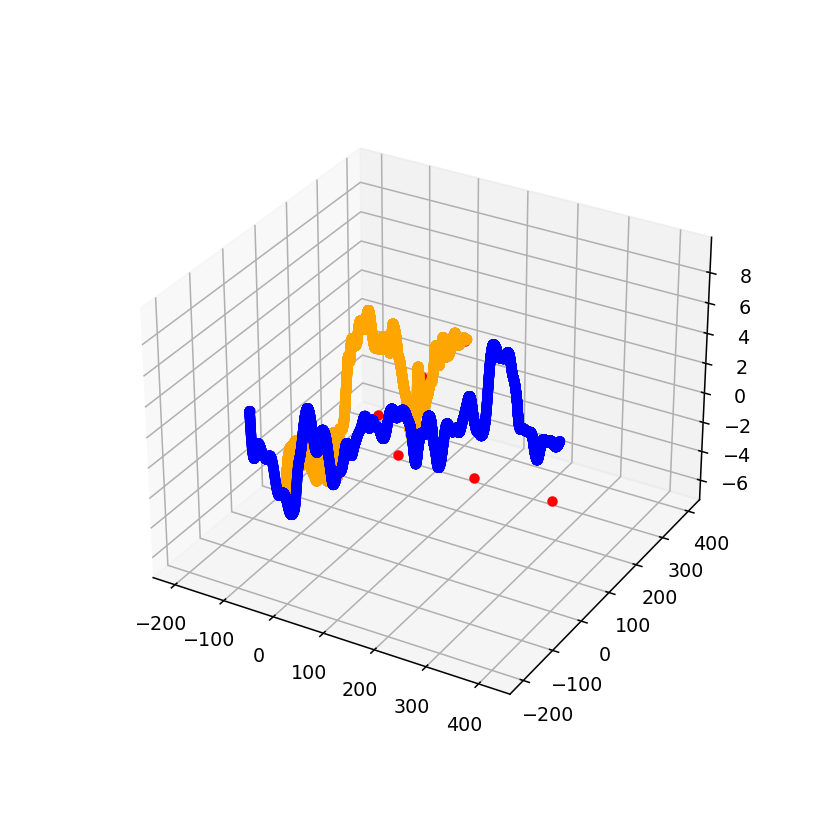

[-200.53358638    0.            0.        ]
[-50.53358638   0.           0.        ]
[99.46641362  0.          0.        ]
[249.46641362   0.           0.        ]
[399.46641362   0.           0.        ]
[-1.22889980e-14 -2.00694568e+02  0.00000000e+00]
[-3.10414705e-15 -5.06945684e+01  0.00000000e+00]
[6.08070395e-15 9.93054316e+01 0.00000000e+00]
[1.52655549e-14 2.49305432e+02 0.00000000e+00]
[2.44504059e-14 3.99305432e+02 0.00000000e+00]


In [12]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(extract_from_df(AC1_GT_Trajectory, 'gt_pos', 0), 
           extract_from_df(AC1_GT_Trajectory, 'gt_pos', 1), 
           extract_from_df(AC1_GT_Trajectory, 'gt_pos', 2), c='b')

ax.scatter(extract_from_df(AC2_GT_Trajectory, 'gt_pos', 0), 
           extract_from_df(AC2_GT_Trajectory, 'gt_pos', 1), 
           extract_from_df(AC2_GT_Trajectory, 'gt_pos', 2), c='orange')

# ax.scatter(AC1_Trk_Trajectory[:,2], 
#            AC1_Trk_Trajectory[:,3],
#            AC1_Trk_Trajectory[:,4], c='orange', alpha=0.5)

# ax.scatter(AC2_Trk_Trajectory[:,2], 
#            AC2_Trk_Trajectory[:,3],
#            AC2_Trk_Trajectory[:,4], c='orange', alpha=0.5)

for wpt in AC1_WPTs:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')
    print(wpt)

for wpt in AC2_WPTs:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')
    print(wpt)

    
# ax.set_xlim(-10, 510)
# ax.set_ylim(-100, 100)
# ax.set_zlim(-50,50)

plt.show()

In [13]:
for tags in GT_ConDet.conflict_definitions.keys():
    if GT_ConDet.history_of_conflict(tags):
        print(tags)

NC1
WC2a
WC1b
WC2b
WC1c
WC2c
WC1d
WC2d
WC1e
WC2e
WC1f
WC2f
WC1g
WC2g
WC1h
WC2h
WC1i
WC2i
WC1j
WC2j
WC3a
WC3b
WC3c
WC3d
WC3e


In [14]:
GT_ConDet.get_earliest_conflict_start_time('WC3a')

2.666666666666694

In [15]:
GT_ConDet.get_earliest_conflict_start_time('WC3b')

2.2916666666666754

In [16]:
res = pd.DataFrame({'Run':[Run], 
                    'AC1_NSE_Radial_Error_Mean':[AC1_GT_Trajectory['gt_hor_err'].mean()], 
                    'AC1_NSE_Radial_Error_Std':[AC1_GT_Trajectory['gt_hor_err'].std()],
                    'AC1_NSE_Mean_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).mean()], 
                    'AC1_NSE_Mean_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).mean()], 
                    'AC1_NSE_Mean_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).mean()], 
                    'AC1_NSE_Std_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).std()], 
                    'AC1_NSE_Std_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).std()], 
                    'AC1_NSE_Std_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).std()], 
                    'AC2_NSE_Radial_Error_Mean':[AC1_GT_Trajectory['gt_hor_err'].mean()], 
                    'AC2_NSE_Radial_Error_Std':[AC1_GT_Trajectory['gt_hor_err'].std()],
                    'AC2_NSE_Mean_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).mean()], 
                    'AC2_NSE_Mean_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).mean()], 
                    'AC2_NSE_Mean_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).mean()], 
                    'AC2_NSE_Std_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).std()], 
                    'AC2_NSE_Std_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).std()], 
                    'AC2_NSE_Std_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).std()]
                   })
for tag in GT_ConDet.conflict_definitions.keys():
    res[tag + '_Start_Time'] = [GT_ConDet.get_earliest_conflict_start_time(tag)]
    res[tag + '_End_Time'] = [GT_ConDet.get_latest_conflict_end_time(tag)]
    res[tag + '_Detected'] = [GT_ConDet.history_of_conflict(tag) & 1]
res

,Run,AC1_NSE_Radial_Error_Mean,AC1_NSE_Radial_Error_Std,AC1_NSE_Mean_x,AC1_NSE_Mean_y,AC1_NSE_Mean_z,AC1_NSE_Std_x,AC1_NSE_Std_y,AC1_NSE_Std_z,AC2_NSE_Radial_Error_Mean,...,WC3b_Detected,WC3c_Start_Time,WC3c_End_Time,WC3c_Detected,WC3d_Start_Time,WC3d_End_Time,WC3d_Detected,WC3e_Start_Time,WC3e_End_Time,WC3e_Detected
0,0,7.444782,4.701184,-4.19115,4.55734,-1.557937,3.950713,4.856048,3.418903,7.444782,...,1,2.033333,20.904167,1,1.854167,20.904167,1,1.716667,20.904167,1


In [17]:
True & 1

1

In [18]:
False & 1

0